## Build the Python Notebook

In [13]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [14]:
project_id = 'qwiklabs-gcp-03-f387bb600872'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [15]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [16]:
# prompt: Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

import pandas as pd
import bigframes.pandas as bpd

# Read the BigQuery table "ecommerce.customer_stats" into a BigFrames DataFrame.
df = bpd.read_gbq("qwiklabs-gcp-03-f387bb600872.ecommerce.customer_stats")

# Display the top 10 rows of the DataFrame.
result = df.head(10)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Reading cached table from 2025-05-13 07:41:06.612194+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
# prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.

import pandas as pd
import bigframes.pandas as bpd
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

project_id = 'qwiklabs-gcp-03-f387bb600872'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"

# 1. Split the data into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# 2. Create a KMeans model with 5 clusters
kmeans = KMeans(n_clusters=5)

# Fit the model to the training data
kmeans.fit(df_train)

# 3. Save the model to BigQuery
kmeans.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

result = kmeans # Store the trained kmeans model as the result

Conflict: 409 Already Exists: Table qwiklabs-gcp-03-f387bb600872:ecommerce.customer_segmentation_model; reason: duplicate, message: Already Exists: Table qwiklabs-gcp-03-f387bb600872:ecommerce.customer_segmentation_model Share your usecase with the BigQuery DataFrames team at the https://bit.ly/bigframes-feedback survey. You are currently running BigFrames version 1.42.0.

In [ ]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

import pandas as pd
import bigframes.pandas as bpd
from bigframes.ml.cluster import KMeans

# Retrieve the trained KMeans model
kmeans = result

# Make predictions on the entire DataFrame
predictions_df = kmeans.predict(df)

# Display the first 10 predictions
result = predictions_df.head(10)

In [21]:
predictions_df

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
0,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.458727445486...",146,951,2,50.724998
1,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.288775753054...",82446,1101,1,95.989998
2,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.888345327777...",38814,1193,4,48.4975
3,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.928633882921...",48364,991,1,39.990002
4,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.691959824538...",11205,898,1,85.0
5,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.389080546060...",50388,1127,2,39.5
6,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.075995483073...",46897,984,1,17.93
7,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.096944381794...",97168,951,1,58.0
8,5,"[{'CENTROID_ID': 5, 'DISTANCE': 2.079746401011...",1346,1160,1,465.0
9,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.267084009412...",66282,933,1,100.0


KeyboardInterrupt: 

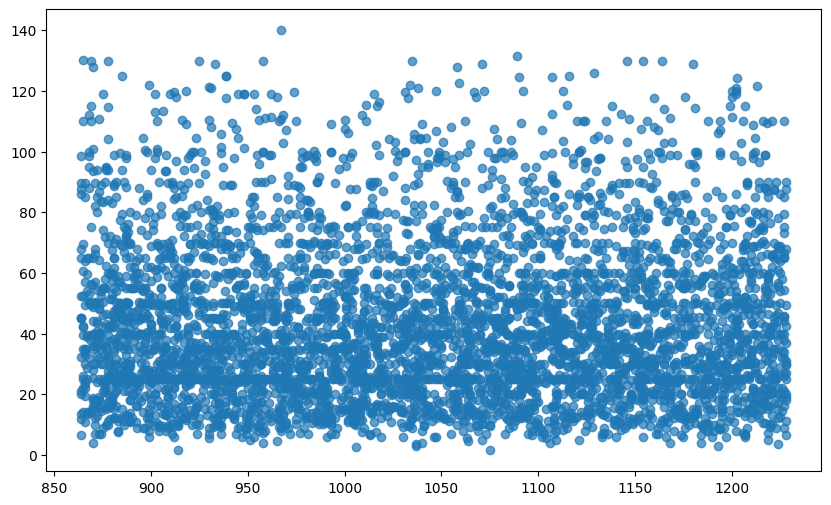

In [22]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."
# the column is
# CENTROID_ID	NEAREST_CENTROIDS_DISTANCE	user_id	days_since_last_order	count_orders	average_spend

import matplotlib.pyplot as plt

# Add the cluster labels to the DataFrame
scatter_df = df.copy()
scatter_df['cluster'] = predictions_df['CENTROID_ID']

# Create the scatter plot
plt.figure(figsize=(10, 6))
for cluster in scatter_df['cluster'].unique():
    plt.scatter(scatter_df[scatter_df['cluster'] == cluster]['days_since_last_order'],
                scatter_df[scatter_df['cluster'] == cluster]['average_spend'],
                label=f'Cluster {cluster}', alpha=0.7)

plt.title('Attribute grouped by K-means cluster')
plt.xlabel('days_since_last_order')
plt.ylabel('average_spend')
plt.legend()
plt.show()


result = plt # Return the plot object as the result

## Generate insights from the results of the model

In [ ]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

In [ ]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

In [ ]:
model = GenerativeModel("gemini-1.0-pro")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "max_output_tokens": 800,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)